In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import os
import io
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import glob

In [3]:
# Library for working with images
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# BASICS OF WORKING WITH IMAGES IN PYTHON

# Load and display the image (PILLOW LIBRARY)
from PIL import Image
img = Image.open('/content/drive/MyDrive/ColabNotebooks/cell.jpeg')
img.show() # can also use "img" alone and run cell to display

# Basic details of the image
print("The size of the image is : " , img.size)
print("The format of the image is : " , img.format)
print("The mode of the image is : " , img.mode)

# Convert to grayscale
img.convert('L')
img.show()

# To convert to different image types eg: png, jpeg etc, just save the image in that format
# img.save("newimg.png")

# Resize the image
img.resize((200, 200)).show()

# To rotate the image
# img.rotate(45)

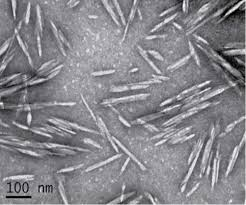

In [3]:
# IMAGE PROCESSING USING CV2

# Load an image
img = cv2.imread('/content/drive/MyDrive/ColabNotebooks/cell.jpeg')
# Display an image
from google.colab.patches import cv2_imshow
cv2_imshow(img)

Text(0, 0.5, 'No of pixels')

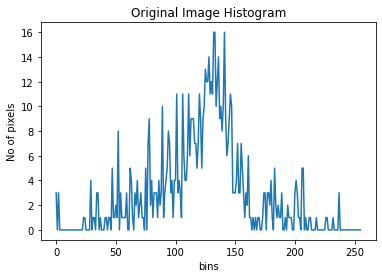

In [4]:
# Histogram of the grayscaled image
histo = cv2.calcHist(img,[0],None,[256],[0,256])
plt.plot(histo)
plt.title('Original Image Histogram')
plt.xlabel('bins')
plt.ylabel("No of pixels")

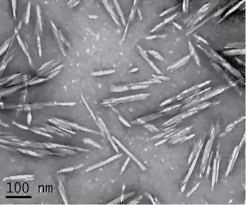

In [5]:
# De-Noising
dnimg = cv2.fastNlMeansDenoising(img, None, 10, 2, 10) 
cv2_imshow(dnimg)

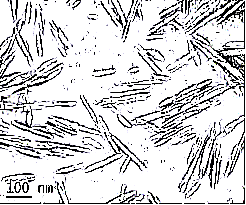

In [6]:
# Image Sharpening
kernel = np.array([[-10, -10, -10], [-10, 85,-10], [-10, -10, -10]])
imgsharp = cv2.filter2D(src=dnimg, ddepth=-1, kernel=kernel)
cv2_imshow(imgsharp)

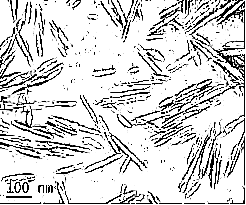

In [7]:
# Convert to grayscale
gimg = cv2.cvtColor(imgsharp, cv2.COLOR_BGR2GRAY)
cv2_imshow(gimg)

Text(0, 0.5, 'No of pixels')

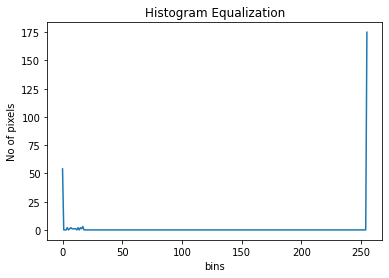

In [8]:
# Histogram Equalization
eqhisto = cv2.equalizeHist(gimg)
# Create the histogram after equalizing
histo2=cv2.calcHist(eqhisto,[0],None,[256],[0,256])
plt.plot(histo2)
plt.title('Histogram Equalization')
plt.xlabel('bins')
plt.ylabel("No of pixels")

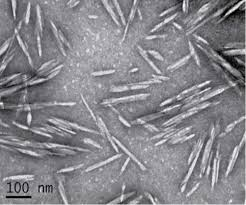

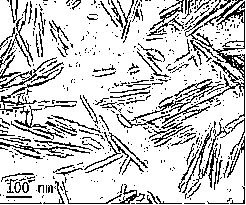

In [9]:
# Display the original and histogram equalized image
cv2_imshow(img)
cv2_imshow(eqhisto)

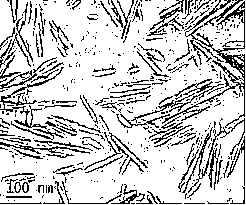

In [10]:
# Thresholding the image to improve contrast
thresh = cv2.adaptiveThreshold(eqhisto, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 3)
cv2_imshow(thresh)

In [13]:
# # K-MEANS SEGMENTATION
# # Reshape image to array
# pvals = imgsharp.reshape((-1,3)) 
# # Convert to float type only for supporting cv2.kmean
# pvals = np.float32(pvals)
# criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 250, 0.5)
# k = 50 # Choosing number of cluster
# retval, labels, centers = cv2.kmeans(pvals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS) 
# centers = np.uint8(centers) 
# segmented_data = centers[labels.flatten()] # Mapping labels to center points(RGB Value)
# segmented_image = segmented_data.reshape((imgsharp.shape))
# plt.imshow(segmented_image)

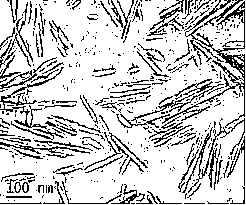

In [11]:
# construct and apply a closing kernel to 'close' gaps between 'white'
# pixels
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
cv2_imshow(closed)

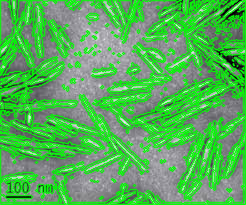

In [18]:
# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(image=closed, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
                                      
# draw contours on the original image
image_copy = img.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
                
# see the results
cv2_imshow(image_copy)

In [39]:
# import the necessary packages
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
# !pip install imutils==0.5.2
import cv2

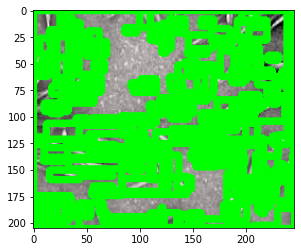

In [40]:
orig = img.copy()
cnts = cv2.findContours(closed, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key= cv2.contourArea, reverse=True)[:200]
for c in cnts:
 peri = cv2.arcLength(c,True)
 apprx = cv2.approxPolyDP(c, 0.1*peri, True)
 x,y,w,h = cv2.boundingRect(apprx)
 cv2.rectangle(orig,(x,y),(x+w,y+h),(0,255,0),5)
plt.imshow(orig)

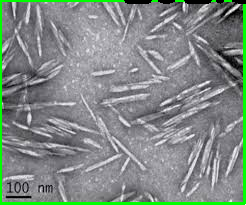

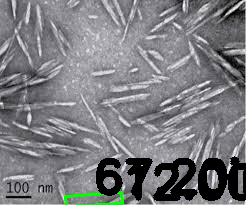

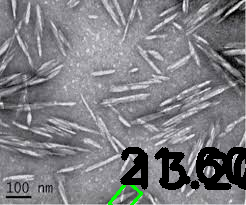

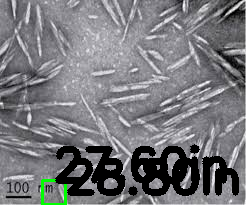

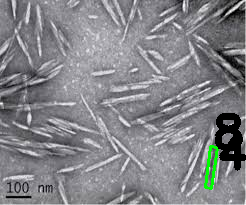

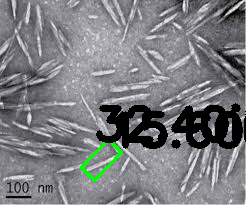

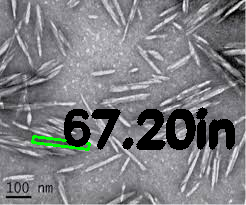

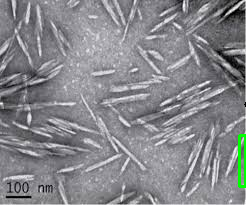

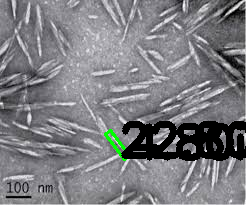

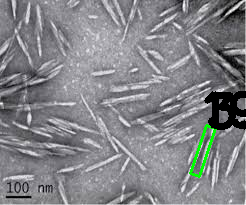

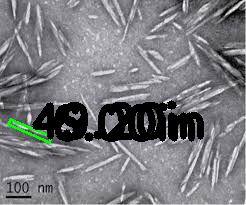

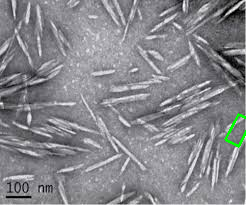

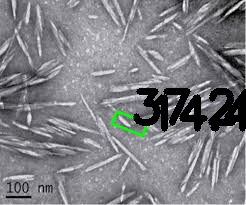

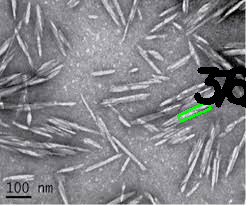

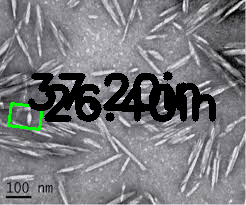

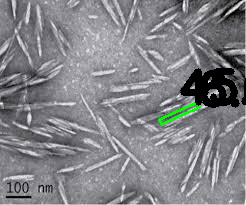

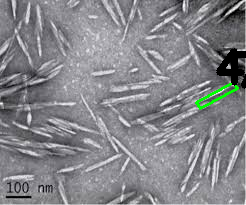

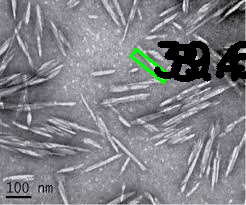

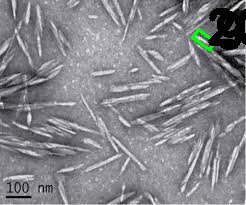

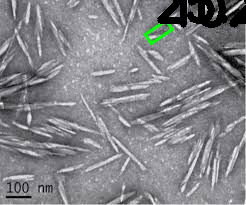

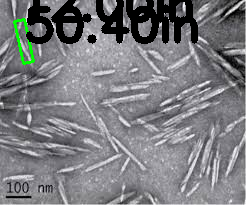

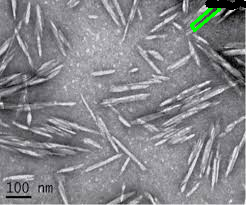

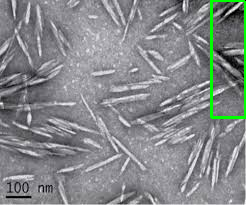

In [50]:
boxes = cv2.findContours(closed, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
boxes = imutils.grab_contours(boxes)
# sort the detected boxes from left to right 
# (boxes, _) = sorted(boxes)
# Initialize the pixels per inch calibration value
pixelsPerInch = None
# loop over the boxes individually
for box in boxes:
	# if the box is not sufficiently large, ignore it
	if cv2.contourArea(box) < 100:
		continue
	# compute the bounding box of the contour
	originalImage = img.copy()
	box = cv2.minAreaRect(box)
	box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
	box = np.array(box, dtype="int")
	# order the points in the contour such that they appear
	# in topLeft, topRight, bottomRight, and bottomLeft
	# order, then draw the outline of the rotated bounding box
	box = perspective.order_points(box)
	(topLeft, topRight, bottomRight, bottomLeft) = box
	# get the width and height of each box in pixels
	vert = bottomLeft[1] - topLeft[1]
	horiz = topRight[0] - topLeft[0]
	# if the pixels per inch has not been initialized, then
	# compute it as the ratio of pixels to supplied referenceWidth in inches
	# assumes first detected object on far left is reference object
	if pixelsPerInch is None:
		pixelsPerInch = 10 / 12
	# compute the width & height of the detected box
	boxHeight = vert / pixelsPerInch
	boxWidth = horiz / pixelsPerInch
	# draw the object sizes on the image
	cv2.drawContours(originalImage, [box.astype("int")], -1, (0, 255, 0), 2)
	# draw dimensions on images
	cv2.putText(originalImage, "{:.2f}in".format(boxWidth),
		(int(topLeft[0]+horiz/2), int(topRight[1])),cv2.FONT_HERSHEY_SIMPLEX,
		1.5, (0, 0, 0), 6)
	cv2.putText(originalImage, "{:.2f}in".format(boxHeight),
		(int(topRight[0]), int(topRight[1]+vert/2)),cv2.FONT_HERSHEY_SIMPLEX,
		1.5, (0, 0, 0), 6)
	# show the output image
	cv2_imshow(originalImage)